This double well potential is not related to SGOOP-d. This is only a demonstration of reweighting method in this repository. If you're familiar with how to reweight metadynamics trajectory and reconstruct an estimate of unbiased free energy, you can skip this file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


In [2]:
# Parameters:
A=1.5
B=1.0
a=1.0
beta=10.0

# data:
x2=np.linspace(-1.5, 1.5, 20)
y2=np.linspace(-1.5, 1.5, 20)
xv2, yv2 = np.meshgrid(x2, y2)
levels=np.linspace(0, 6.0, 10) # levels of contour plot.


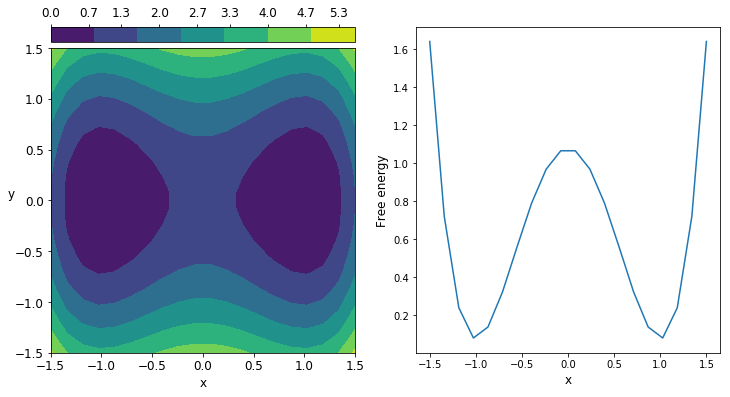

In [3]:
def u_dw(xx, B, a):
    d_xx = xx**2-a
    return B*d_xx**2

def u_y(yy, A):
    return A*(yy**2)

def u2(xx, yy, A, B, a):
    return u_dw(xx, B, a)+u_y(yy, A)

def mean_f2_x(xx, A, B, a, beta):
    """
    potential of mean force in x direction.
    """
    min_y, max_y = -500.0, 500.0
    Nslice = 10000
    yy = np.linspace(min_y, max_y, Nslice)
    dy = (max_y - min_y)/Nslice
    fy = np.exp(-beta*u2(xx, yy, A, B, a))
    I = np.sum(fy*dy)    
    return (-1/beta)*np.log(I)

fE2=u2(xv2, yv2, A, B, a)
pmf2_x=np.array([mean_f2_x(xi, A, B, a, beta) for xi in x2])

fig, ax=plt.subplots(figsize=(12,6), nrows=1, ncols=2)
ctrp=ax[0].contourf(x2, y2, fE2)
ax[1].plot(x2, pmf2_x)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 6.0 , 10), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12) 

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)

ax[1].set_xlabel('x', size=12)
ax[1].set_ylabel('Free energy', size=12)

plt.show()

# Computation

## Unbiased result:

In [4]:
filename='./DATA_dw/unbiased/xvyw1beta10.0gammax1.0gammay1.0epsln1.0sgma1.0A1.5x01.122w1.2B1.0a1.0_h0.01.txt'
x, y = np.loadtxt(filename, unpack=True, usecols=(0,1), skiprows=1)

# parameters:
beta=10
Rout = 100 # output rate.
coeff_x, coeff_y = (1.0, 0.0)

# data:
levels=np.linspace(0, 3.0, 12) # levels of contour plot.

hist2d=np.histogram2d(x, y, bins=50)
prob2d=hist2d[0].T/np.sum(hist2d[0])
freeE2d=(-1/beta)*np.log(prob2d+1e-11)
x2d=0.5*(hist2d[1][1:]+hist2d[1][:-1])
y2d=0.5*(hist2d[2][1:]+hist2d[2][:-1])

hist1d=np.histogram(coeff_x*x+coeff_y*y, bins=50)
prob1d=hist1d[0].T/np.sum(hist1d[0])
freeE1d=(-1/beta)*np.log(prob1d+1e-11)
x1d=0.5*(hist1d[1][1:]+hist1d[1][:-1])


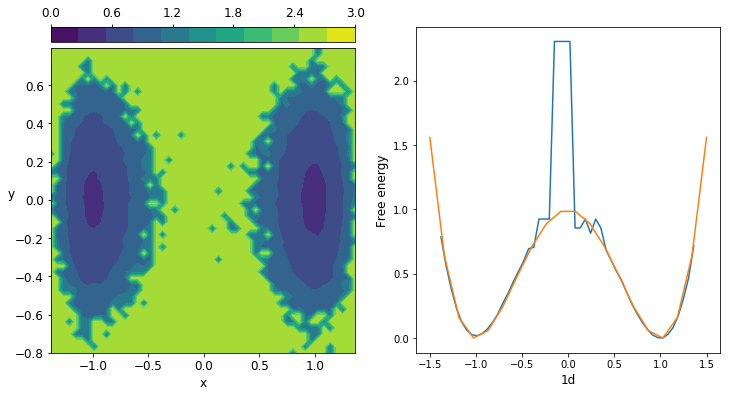

In [5]:
# Plottings:
fig, ax=plt.subplots(figsize=(12,6), nrows=1, ncols=2)
ax=ax.flatten()

ctrp = ax[0].contourf(x2d, y2d, freeE2d, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 3.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)

ax[1].plot(x1d, freeE1d-np.min(freeE1d))
ax[1].plot(x2, pmf2_x-np.min(pmf2_x))
ax[1].set_xlabel('1d', size=12)
ax[1].set_ylabel('Free energy', size=12)

plt.show()

## Biased result:

The units in the output file are "lines". <br>
The output rate is denoted as "Rout". <br>
Each line corresponding to "Rout" steps in simulation.

In [6]:
filename='./DATA_dw/h0_1_w0_1_db1_0_stride200_cx1_0_cy0_0/xvyw1beta10.0gammax1.0gammay1.0epsln1.0sgma1.0A1.5x01.122w1.2B1.0a1.0_h0.01.txt'
x, y, hbias, xbias, ybias = np.loadtxt(filename, unpack=True, usecols=(0,1, 6,7,8), skiprows=1)

# parameters:
beta=10
Rout = 100 # output rate.
coeff_x, coeff_y = (1.0, 0.0)
stride=200 # in unit of steps.
stride = stride//Rout # in unit of lines.
wbias=0.1
delta_beta=1.0

# data:
s=coeff_x*x+coeff_y*y
sbias=coeff_x*xbias+coeff_y*ybias
levels=np.linspace(0, 3.0, 12)


In [7]:
def Vbias(s, hbias, sbias, wbias):
    """
    sum of biases added at position s.
    """
    Vbias = np.sum(hbias*np.exp(-0.5*(s-sbias)**2/wbias**2))
    return Vbias

def exp_beta_Vbias(s, nline, hbias, sbias, wbias, beta):
    """
    exp(beta*Vbias)
    Number of hbias and sbias should less than or equal to nline.
    """
    if nline<len(hbias) or nline<len(sbias):
        raise TypeError
    
    Vbias = np.sum(hbias*np.exp(-0.5*(s-sbias)**2/wbias**2))
    return np.exp(beta*Vbias)

def exp_beta_c(nline, hbias, sbias, wbias, beta, delta_beta):
    """
    exp(beta*c[nline]) # nline is t in unit of lines.
    Number of hbias and sbias should less than or equal to nline.
    """
    # if the following statement is not true, the causality breaks.
    if nline<len(hbias) or nline<len(sbias):
        raise ValueError
    # nline=0 is the initial configuration. Without this line, the following sb_max/sb_min break.
    if nline==0: 
        return 1
    
    T, dT = 1/beta, 1/delta_beta
    exp_num, exp_den = (T+dT)/dT, T/dT
    
    ds=0.05 # integration interval
    sb_max=np.max(sbias)+3*ds
    sb_min=np.min(sbias)-3*ds

    num=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_num for ss in np.arange(sb_min, sb_max, ds)])
    den=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_den for ss in np.arange(sb_min, sb_max, ds)])
    
    return num/den


In [8]:
# Construct reweighting array. Since this is usually slow, it was isolated here.
weights=np.zeros(s.shape[0])
for i, si in enumerate(s):
    sbias_t=sbias[:i:stride]
    hbias_t=hbias[:i:stride]
    weights[i]=exp_beta_Vbias(si, i, hbias_t, sbias_t, wbias, beta)/exp_beta_c(i, hbias_t, sbias_t, wbias, beta, delta_beta)


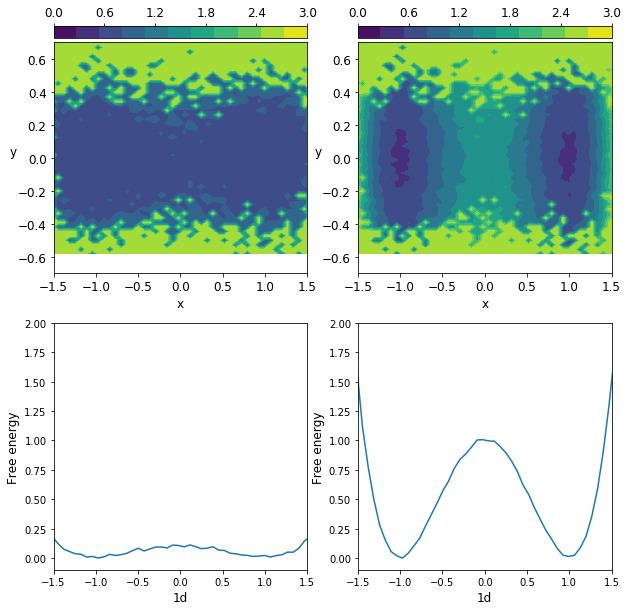

In [9]:
# data:
hist2d=np.histogram2d(x, y, bins=50)
prob2d=hist2d[0].T/np.sum(hist2d[0])
freeE2d=(-1/beta)*np.log(prob2d+1e-11)
x2d=0.5*(hist2d[1][1:]+hist2d[1][:-1])
y2d=0.5*(hist2d[2][1:]+hist2d[2][:-1])

rw_hist2d=np.histogram2d(x, y, weights=weights, bins=50)
rw_prob2d=rw_hist2d[0].T/np.sum(rw_hist2d[0])
rw_freeE2d=(-1/beta)*np.log(rw_prob2d+1e-11)
rw_x2d=0.5*(rw_hist2d[1][1:]+rw_hist2d[1][:-1])
rw_y2d=0.5*(rw_hist2d[2][1:]+rw_hist2d[2][:-1])

hist1d=np.histogram(coeff_x*x+coeff_y*y, bins=50)
prob1d=hist1d[0].T/np.sum(hist1d[0])
freeE1d=(-1/beta)*np.log(prob1d+1e-11)
x1d=0.5*(hist1d[1][1:]+hist1d[1][:-1])

rw_hist1d=np.histogram(coeff_x*x+coeff_y*y, weights=weights, bins=50)
rw_prob1d=rw_hist1d[0].T/np.sum(rw_hist1d[0])
rw_freeE1d=(-1/beta)*np.log(rw_prob1d+1e-11)
rw_x1d=0.5*(rw_hist1d[1][1:]+rw_hist1d[1][:-1])

# Plottings:
fig, ax=plt.subplots(figsize=(10,10), nrows=2, ncols=2)
ax=ax.flatten()

ctrp = ax[0].contourf(x2d, y2d, freeE2d, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 3.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ctrp = ax[1].contourf(rw_x2d, rw_y2d, rw_freeE2d, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 3.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[2].plot(x1d, freeE1d-np.min(freeE1d))

ax[3].plot(rw_x1d, rw_freeE1d-np.min(rw_freeE1d))

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-0.7, 0.7)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('x', size=12)
ax[1].set_ylabel('y', size=12).set_rotation(0)
ax[1].set_xlim(-1.5, 1.5)
ax[1].set_ylim(-0.7, 0.7)

ax[2].set_xlabel('1d', size=12)
ax[2].set_ylabel('Free energy', size=12)
ax[2].set_xlim(-1.5, 1.5)
ax[2].set_ylim(-0.1,2.0)

ax[3].set_xlabel('1d', size=12)
ax[3].set_ylabel('Free energy', size=12)
ax[3].set_xlim(-1.5, 1.5)
ax[3].set_ylim(-0.1,2.0)

plt.show()


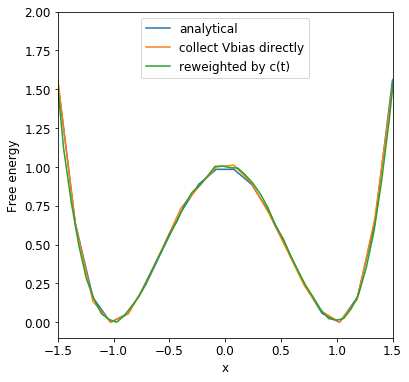

In [10]:
# parameters:
T, dT = 1/beta, 1/delta_beta
prefactor=-(T+dT)/dT

# data (The bias is added every stride):
rw_fE=prefactor*np.array([Vbias(xi, hbias[::stride], sbias[::stride], wbias) for xi in x2])

# Plottings:
fig, ax=plt.subplots(figsize=(6,6), nrows=1, ncols=1)

ax.plot(x2, pmf2_x-np.min(pmf2_x), label='analytical')
ax.plot(x2, rw_fE-np.min(rw_fE), label='collect Vbias directly')
ax.plot(rw_x1d, rw_freeE1d-np.min(rw_freeE1d), label='reweighted by c(t)')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', size=12)
ax.set_ylabel('Free energy', size=12)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-0.1, 2.0)
ax.legend(loc='upper center', fontsize=12)

plt.show()
